In [1]:
import torch
import pandas as pd
import numpy as np
import pickle, logging, spacy, sys, os, json, requests
import matplotlib.pyplot as plt

from helpers.classes import Collection
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
from helpers.configs import CLOZE_MASKS

from helpers.cloze_generation import generate_clozes_from_point, named_entity_answer_generator as ne_answer_generator, noun_phrase_answer_generator as np_answer_generator

from helpers.table_processing import preprocess_table, read_process_table, find_relevant_column_header, find_relevant_content
from helpers.t5_language_model import summarise_t5_results


# df = pd.read_pickle('pickles/dataset_20210625_184837.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210807_165700.json')

df = pd.read_pickle('pickles/collection_20210624_194932.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210824.json')
clozes_df = pd.read_json('pickles/clozes_with_false_20210825.json') #contains negs

clozes_df['answer_type_agg'] = clozes_df['answer_type'].apply(
    lambda x: CLOZE_MASKS.get(x))

In [3]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('fivethirtyeight')

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [4]:
unique_bulletins_reldata = clozes_df[['bulletin', 'data']]
unique_bulletins_reldata = unique_bulletins_reldata.loc[unique_bulletins_reldata.astype(str).drop_duplicates().index]


datalookup = dict()
for _, row in unique_bulletins_reldata.iterrows():
    bulletin = row.bulletin
    reldata = row.data
    for data in reldata:
        current = datalookup.get(data, set())
        current.add(bulletin)
        datalookup[data] = current


num_of_bulletins_per_dataset = []
for k in datalookup:
    num_of_bulletins_per_dataset.append(len(datalookup.get(k)))

In [5]:
print(f'number of bulletins: {clozes_df.bulletin.nunique()}')
print(f'number of unique cloze_text: {clozes_df.cloze_text.nunique()}')
print(f'average number of datasets per bulletin: {clozes_df.data.apply(lambda x: len(x)).values.mean()} ({clozes_df.data.apply(lambda x: len(x)).values.std()})')
print(f"average number of words per cloze: {clozes_df.source_text.apply(lambda x: len(x.split(' '))).values.mean()} ({clozes_df.source_text.apply(lambda x: len(x.split(' '))).values.std()})")
print(f"average extracted sentences per bulletin: {clozes_df.groupby('bulletin').source_text.nunique().values.mean()} ({clozes_df.groupby('bulletin').source_text.nunique().values.std()})")
print(f"average generated clozes per sentence: {clozes_df.groupby(['bulletin', 'source_text']).cloze_text.nunique().values.mean()} ({clozes_df.groupby(['bulletin', 'source_text']).cloze_text.nunique().values.std()})")
print(f"average generated clozes per bulletin: {clozes_df.groupby('bulletin').cloze_text.nunique().values.mean()} ({clozes_df.groupby('bulletin').cloze_text.nunique().values.std()})")
print(f'number of bulletins per dataframe: {np.mean(num_of_bulletins_per_dataset), np.std(num_of_bulletins_per_dataset)}')

number of bulletins: 382
number of unique cloze_text: 6154
average number of datasets per bulletin: 3.0722833117723156 (2.9771849510570245)
average number of words per cloze: 28.076326002587322 (7.530833279998634)
average extracted sentences per bulletin: 4.7408376963350785 (3.425093315477816)
average generated clozes per sentence: 3.414688017669796 (1.9393864836687364)
average generated clozes per bulletin: 16.18848167539267 (12.739273212702683)
number of bulletins per dataframe: (1.1995614035087718, 0.5356581299621256)


In [6]:
print(clozes_df[
    ['cloze_text', 'answer_text', 'answer_type', 'answer_type_agg', 'bulletin', 'data']
    ].head().to_latex())

\begin{tabular}{lllllll}
\toprule
{} &                                         cloze\_text &       answer\_text & answer\_type & answer\_type\_agg &                                           bulletin &                                               data \\
\midrule
0 &  In TEMPORALMASK, approximate gross value added... &              2019 &        DATE &    TEMPORALMASK &  businessindustryandtrade/business/businessserv... &  [/businessindustryandtrade/business/businessse... \\
1 &  In 2019, approximate gross value added at basi... &  £1,313.9 billion &       MONEY &     NUMERICMASK &  businessindustryandtrade/business/businessserv... &  [/businessindustryandtrade/business/businessse... \\
2 &  In 2019, approximate gross value added at basi... &     £42.8 billion &       MONEY &     NUMERICMASK &  businessindustryandtrade/business/businessserv... &  [/businessindustryandtrade/business/businessse... \\
3 &  In 2019, approximate gross value added at basi... &              3.4\% &     PERCE

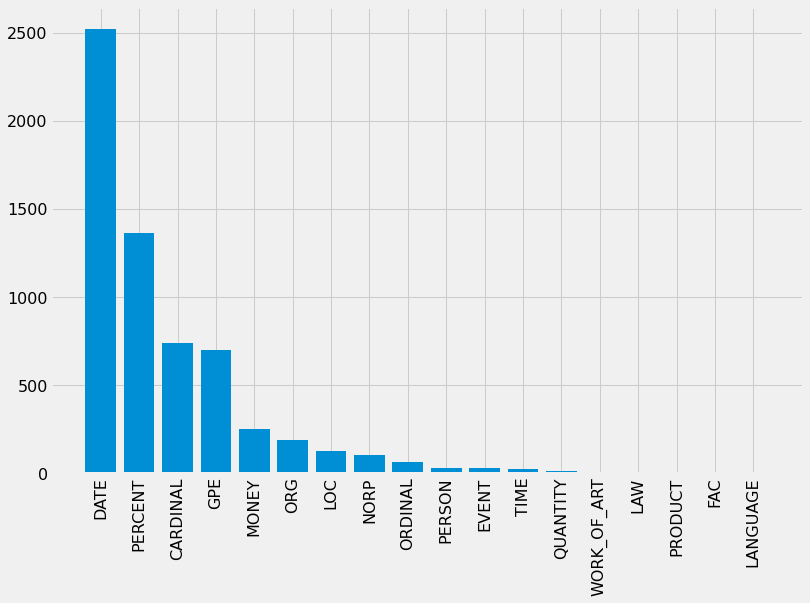

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.bar(
    height = clozes_df.answer_type.value_counts().values,
    x = clozes_df.answer_type.value_counts().keys().values)
# plt.hist(clozes_df.answer_type)
plt.xticks(rotation = 90)
plt.savefig(
    'images/distribution_of_answertypes.png',
    facecolor = 'white', bbox_inches = 'tight')
plt.show()

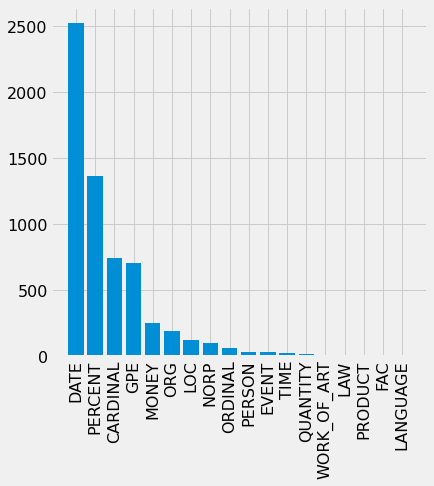

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plt.bar(
    height = clozes_df.answer_type.value_counts().values,
    x = clozes_df.answer_type.value_counts().keys().values)
# plt.hist(clozes_df.answer_type)
plt.xticks(rotation = 90)
plt.savefig(
    'images/distribution_of_answertypes_2.png',
    facecolor = 'white', bbox_inches = 'tight')
plt.show()

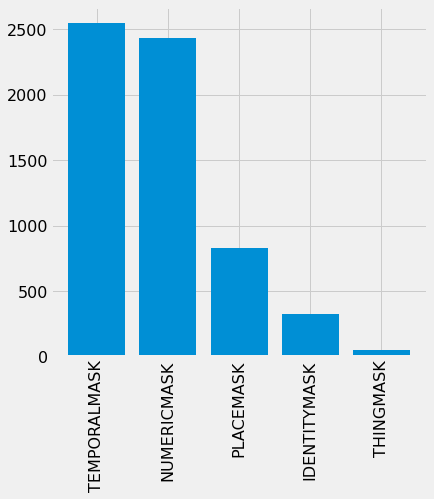

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plt.bar(
    height = clozes_df.answer_type_agg.value_counts().values,
    x = clozes_df.answer_type_agg.value_counts().keys().values)
# plt.hist(clozes_df.answer_type)
plt.xticks(rotation = 90)
plt.savefig(
    'images/distribution_of_answertypes_2b.png',
    facecolor = 'white', bbox_inches = 'tight')
plt.show()

In [23]:
source_lengths = [len(x)for x in clozes_df.source_text]

lengths = pd.DataFrame({'lens': source_lengths, 'type': clozes_df.answer_type})

<AxesSubplot:ylabel='Frequency'>

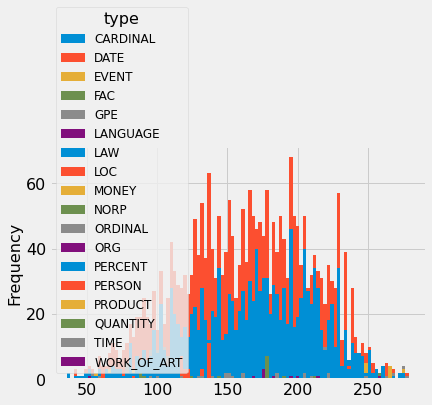

In [35]:
lengths.pivot(columns= 'type', values = 'lens').plot.hist(bins = 100)

In [7]:
clozes_df

,cloze_text,source_text,true,false,answer_text,answer_type,answer_length,ids,bulletin,data,answer_type_agg
0,"In TEMPORALMASK, approximate gross value added...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In the years 2013 to 2017, approximate gross v...",2019,DATE,1,ccf75a2c157eacc5253f0e8a55b1ded9f5386d58,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...,TEMPORALMASK
1,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","£1,313.9 billion",MONEY,2,fc3346f2545ca5059bdb5150b998300c5001bea5,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...,NUMERICMASK
2,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",£42.8 billion,MONEY,2,81aa32270d547a368e7b806646c72069ba4fac43,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...,NUMERICMASK
3,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",3.4%,PERCENT,1,f308eb661ad1d6c8021cf9e22d8e8c7d9c5ff50e,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...,NUMERICMASK
4,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",2018,DATE,1,0a0bcf4b990f1926bc87fa662badadaf7e23d5fa,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...,TEMPORALMASK
...,...,...,...,...,...,...,...,...,...,...,...
6179,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,76%,PERCENT,1,dce8c5e1d183452a3cc887d90ff0f64ef4bb82b5,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...,NUMERICMASK
6180,"In comparison, NUMERICMASK of people did not f...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, 46.6% of people did not feel si...",around 14%,PERCENT,2,e7c1fce9fcd8c918a07029ba4266c18391b1aa75,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...,NUMERICMASK
6181,"In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...",38%,PERCENT,1,874948014cfa36eff9f493b57e8077f3bda23019,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...,NUMERICMASK
6182,Some of the main UK findings (Source: IDENTITY...,Some of the main UK findings (Source: Understa...,Some of the main UK findings (Source: Understa...,Some of the main UK findings (Source: NHS Isle...,Understanding Society,ORG,2,fab3e03bd458df568f3d110940583bc1251dfd90,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...,IDENTITYMASK


In [169]:
answers_text_type = clozes_df[['answer_text', 'answer_type']].value_counts()

In [214]:
# number of words in answer text
temp = clozes_df[['answer_text', 'answer_type']]
temp['answer_words'] = temp.answer_text.apply(lambda x: len(x.split(' ')))
temp.answer_words.describe()

<ipython-input-214-6ce5b25f82b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['answer_words'] = temp.answer_text.apply(lambda x: len(x.split(' ')))


count    6184.000000
mean        1.860446
std         1.353592
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: answer_words, dtype: float64

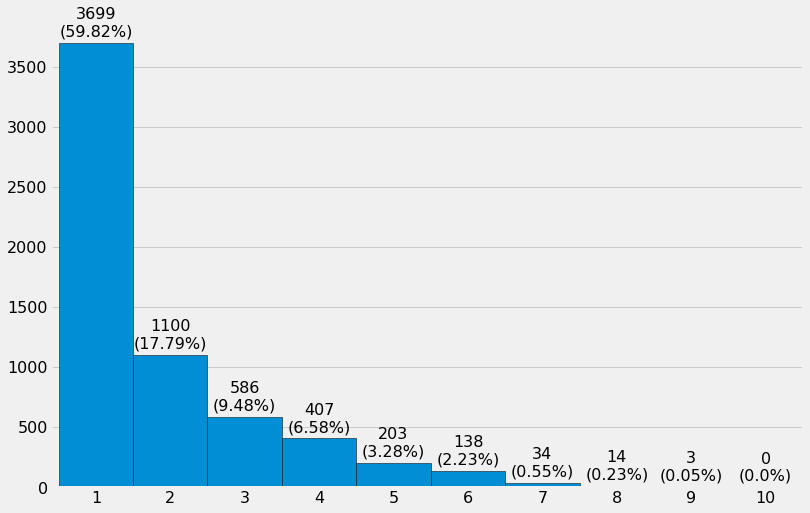

In [98]:
bins = np.arange(1,12)
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
counts, _, patches = ax.hist(
    clozes_df.answer_length, 
    bins=bins,
    edgecolor='black',
    align='mid')

perc_counts = [(x * 100 ) / np.sum(counts) for x in counts]

annotations = [str(int(x)) + f'\n({str(np.round(y, 2))}%)' for x,y in zip(counts, perc_counts)]

for annot, patch in zip(annotations,patches):
    ax.annotate(
        annot,
        xy=(patch.get_x() + 0.5, patch.get_height()+55), ha ='center')

plt.xticks(np.arange(1+0.5, 12, 1), np.arange(1, 12))
ax.grid(False)
ax.yaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')
ax.set_xlim(0.9, 11)
plt.savefig(
    'overleaf_peripherals/distribution_of_num_words_answer.png',
    facecolor = 'white', bbox_inches = 'tight')

plt.show()



In [133]:
# sampled = [clozes_df.loc[clozes_df.answer_length == x].sample(3) for x in np.arange(1, 10)]

# with open('secondary/sampled_answers.pickle', 'wb') as f:
#     pickle.dump(sampled, f)

# with open('secondary/sampled_answers.txt', 'w') as f:
#     for i, sample_length in enumerate(sampled):
#         f.write(str(i+1) + '\n')
#         strings = [f'Cloze: {x}\n__Answer: {y}++\n' for x, y in zip(sample_length['cloze_text'], sample_length['answer_text'])]
#         for string in strings:
#             f.write(string)
        
#         f.write('\n')

In [151]:
sampled[4].iloc[1].cloze_text

'Amphetamine use in the last year in adults aged 16 to 59 years fell by 42% compared with the previous year (to 109,000 people), continuing the long-term decline since TEMPORALMASK.'

In [159]:
clozes_df.loc[clozes_df.ids == '3cd03384ce560f6010488476ac4ffe85d579105f'].cloze_text.values

array(['Amphetamine use in the last year in adults aged 16 to 59 years fell by NUMERICMASK compared with the previous year (to 109,000 people), continuing the long-term decline since the year ending December 1995.'],
      dtype=object)

In [163]:
sampled[8]

,cloze_text,source_text,true,false,answer_text,answer_type,answer_length,ids,bulletin,data,answer_type_agg
2149,"In England, people identifying as Muslim, Hind...","In England, people identifying as Muslim, Hind...","In England, people identifying as Muslim, Hind...","In England, people identifying as Muslim, Hind...",the period 24 January 2020 to 28 February 2021,DATE,9,385ce0e09a36f67f5c4b7f9ea825e4956ecb8165,peoplepopulationandcommunity/birthsdeathsandma...,[/peoplepopulationandcommunity/birthsdeathsand...,TEMPORALMASK
886,"General government gross debt was £1,601.3 bil...","General government gross debt was £1,601.3 bil...","General government gross debt was £1,601.3 bil...","General government gross debt was £1,601.3 bil...",the end of the financial year ending March 2015,DATE,9,67f2d1bb5a6b3ff55655733142b3c0edc5b5a47e,economy/governmentpublicsectorandtaxes/publics...,[/economy/governmentpublicsectorandtaxes/publi...,TEMPORALMASK
889,"General government gross debt was £1,601.3 bil...","General government gross debt was £1,601.3 bil...","General government gross debt was £1,601.3 bil...","General government gross debt was £1,601.3 bil...",the end of the financial year ending March 2014,DATE,9,1c5791275b1f039ab88d026b22ad5908b4c7c0de,economy/governmentpublicsectorandtaxes/publics...,[/economy/governmentpublicsectorandtaxes/publi...,TEMPORALMASK


In [195]:
sampled[4].iloc[1].data

['/peoplepopulationandcommunity/crimeandjustice/datasets/drugmisuseinenglandandwalesappendixtable']

In [198]:
len(pd.ExcelFile('datasets/peoplepopulationandcommunity_crimeandjustice_datasets_drugmisuseinenglandandwalesappendixtable.xls').sheet_names)

41

In [240]:
subcats = []
subcat_dict = dict()
for k in df.sections:
    subcats.append(list(df.sections.get(k).keys()))
    subcat_dict[k] = list(df.sections.get(k).keys())
    
subcategories = [item for sub in subcats for item in sub]

In [239]:
len(subcategories)

31

In [244]:
for k in subcat_dict:
    print(f'category: {k}')
    print(f'subcat: {subcat_dict.get(k)}\n')

category: businessindustryandtrade
subcat: ['business', 'changestobusiness', 'constructionindustry', 'itandinternetindustry', 'internationaltrade', 'manufacturingandproductionindustry', 'retailindustry', 'tourismindustry']

category: economy
subcat: ['economicoutputandproductivity', 'environmentalaccounts', 'governmentpublicsectorandtaxes', 'grossdomesticproductgdp', 'grossvalueaddedgva', 'inflationandpriceindices', 'investmentspensionsandtrusts', 'nationalaccounts', 'regionalaccounts']

category: employmentandlabourmarket
subcat: ['peopleinwork', 'peoplenotinwork']

category: peoplepopulationandcommunity
subcat: ['birthsdeathsandmarriages', 'crimeandjustice', 'culturalidentity', 'educationandchildcare', 'elections', 'healthandsocialcare', 'householdcharacteristics', 'housing', 'leisureandtourism', 'personalandhouseholdfinances', 'populationandmigration', 'wellbeing']



In [245]:
subcat_dict.keys()

dict_keys(['businessindustryandtrade', 'economy', 'employmentandlabourmarket', 'peoplepopulationandcommunity'])